# 0. Prepare Project

In [215]:
from typing import List
%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path

from promg.modules.db_management import DBManagement
from tabulate import tabulate
import yaml

from promg import Configuration, DatabaseConnection, Performance, SemanticHeader, DatasetDescriptions, OcedPg, Query

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd

pd.set_option('display.width', 2000)

### Define the project that you want to do analysis on

In [216]:
case_study = 'bpic14'
use_sample = False

In [217]:
# retrieve configuration for case_study
conf_path = Path(case_study, 'config.yaml')
config = yaml.safe_load(open(conf_path))

print(f"These are the credentials that I expect to be set for the database.")
print(f"db_name: {config['db_name']}")
print(f"uri: {config['uri']}")
print(f"password: {config['password']}")
print("----------------------")
print(f"If you have other credentials, please change them at: {conf_path}")

These are the credentials that I expect to be set for the database.
db_name: neo4j
uri: bolt://localhost:7687
password: bpic2014
----------------------
If you have other credentials, please change them at: bpic14\config.yaml


### Prepare so we can use PromG to load the data and execute queries

In [218]:
config = Configuration.init_conf_with_config_file(conf_path)
db_connection = DatabaseConnection.set_up_connection(config=config)
perf = Performance.set_up_performance(config=config)
dataset_descriptions = DatasetDescriptions(config=config)

In [219]:
def reset_pbar(pbar=perf.pbar, total=None):
    # clear db
    pbar.reset()
    # TODO update dragons in PromG, #update method to set total for pbar
    pbar.total = total
    pbar.set_postfix_str()

#### Prepare the DB

In [220]:
# read the semantic header --> this details how the data should be structured
semantic_header = SemanticHeader.create_semantic_header(config=config)

In [221]:
# Clear the DB (if use_sample = False, this should not take long on a loaded database)
db_manager = DBManagement(db_connection=db_connection, semantic_header=None)
db_manager.clear_db(
    replace=True);  # in the community version of neo4j, replace is not allowed. In that case, set replace=False

13it [3:41:44, 2632.11s/it, clear_db: took 13274.12 seconds]                                          

### Statistics

In [222]:
def get_graph_statistics(_db_connection):
    """
    Statistics about nodes and relations.
    """

    with _db_connection.driver.get_session(database=_db_connection.db_name) as session:
        print("\n=== GRAPH STATISTICS ===")

        try:
            node_query = """
            MATCH (n)
            WITH n, labels(n) as labels
            RETURN reduce(label_str = "(", l in labels | label_str + ":" + l) + ")" as label, count(n) as count ORDER BY count DESC
            """
            node_counts = session.run(node_query)
            print("\n--- Node counts ---")
            for record in node_counts:
                print(f"{record['label']:<30} {record['count']}")

            rel_query = """
            MATCH (n) - [r] -> (n2)
            RETURN "[:" + type(r) + "]" as  type, count(r) as count ORDER BY count DESC
            """
            rel_counts = session.run(rel_query)
            print("\n--- Relationship counts ---")
            for record in rel_counts:
                print(f"{record['type']:<30} {record['count']}")

            total_nodes = session.run("MATCH (n) RETURN count(n) AS total").single()["total"]
            total_rels = session.run("MATCH ()-[r]->() RETURN count(r) AS total").single()["total"]

            print("\n--- Totals ---")
            print(f"Total nodes: {total_nodes}")
            print(f"Total relationships: {total_rels}")

        except Exception as e:
            print(f"Failed to get graph statistics: {e}")

# 0. Load the data

In [223]:
use_sample = False
oced_pg = OcedPg(database_connection=db_connection,
                 dataset_descriptions=dataset_descriptions,
                 semantic_header=semantic_header,
                 use_sample=use_sample)


In [224]:
# first, we load all records
# (if use_sample = False, this should take less than 2 minutes)
reset_pbar(total=11)
oced_pg.load();

  0%|          | 0/11 [00:00<?, ?it/s]                                 

Received notification from DBMS server: <GqlStatusObject gql_status='01N50', status_description='warn: label does not exist. The label `Log` does not exist. Verify that the spelling is correct.', position=<SummaryInputPosition line=2, column=22, offset=22>, raw_classification='UNRECOGNIZED', classification=<NotificationClassification.UNRECOGNIZED: 'UNRECOGNIZED'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'UNRECOGNIZED', '_severity': 'WARNING', '_position': {'offset': 22, 'line': 2, 'column': 22}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: '\n            MATCH (l:Log)\n            RETURN COLLECT(DISTINCT l.name) AS logs\n        '
Received notification from DBMS server: <GqlStatusObject gql_status='01N52', status_description='warn: property key does not exist. The property `name` does not exist. Verify that the spelling is correct.', position=<SummaryInputPosition line=3, column=39, 

100%|██████████| 11/11 [00:31<00:00,  2.95s/it, _filter_nodes for BPIC14Interaction: took 0.0 seconds]                     

In [225]:
get_graph_statistics(db_connection)


=== GRAPH STATISTICS ===

--- Node counts ---
(:Record)                      690622
(:Log)                         4

--- Relationship counts ---
[:CONTAINS]                    690622

--- Totals ---
Total nodes: 690626
Total relationships: 690622


In [226]:
bpic14_incident = "BPIC14Incident.csv"
bpic14_interaction = "BPIC14Interaction.csv"
bpic14_change = "Detail_Change.csv"
bpic14_incident_activity = "Detail_Incident_Activity.csv"

# 1. Split Entities into Objects and Events

### Objects Nodes

Create objects out of the Record nodes directly.
Those are I
- Incident
- Interaction
- Change
- Knowledge Document
- Resource.

In [227]:
objects = {
    "Incident": [
        {
            "log": bpic14_incident,
            "sysId": "incidentId",
            "attributes": {
                "incidentId": "incidentId",
                "status": "status",
                "impact": "impact",
                "priority": "priority",
                "category": "category",
                "handleTimeHours": "handleTimeHours",
                "closureCode": "closureCode",
                "alertStatus": "alertStatus",
                "numReassignments": "numReassignments",
                "numRelatedInteractions": "numRelatedInteractions",
                "numRelatedIncidents": "numRelatedIncidents",
                "numRelatedChanges": "numRelatedChanges"
            },
        },
        {
            "log": bpic14_interaction,
            "sysId": "relatedIncident",
            "attributes": {
                "incidentId": "relatedIncident"
            },
            "constants": {
                "derivedFromInteraction": True
            }
        },

        {
            "log": bpic14_incident_activity,
            "sysId": "incidentId",
            "attributes": {
                "incidentId": "incidentId"
            }
        }
    ],
    "Interaction": [
        {
            "log": bpic14_interaction,
            "sysId": "interactionId",
            "attributes": {
                "interactionId": "interactionId",
                "status": "status",
                "impact": "impact",
                "priority": "priority",
                "category": "category",
                "handleTimeSecs": "handleTimeSecs",
                "closureCode": "closureCode",
                "firstCallResolution": "firstCallResolution"
            },
        },
        {
            "log": bpic14_incident,
            "sysId": "relatedInteraction",
            "attributes": {
                "interactionId": "relatedInteraction"
            },
        }
    ],
    "Change": [
        {
            "log": bpic14_change,
            "sysId": "changeId",
            "attributes": {
                "changeId": "changeId",
                "type": "changeType",
                "riskAssessment": "riskAssessment",
                "cabApprovalNeeded": "cabApprovalNeeded",
                "plannedStart": "plannedStart",
                "plannedEnd": "plannedEnd",
                "scheduledDowntimeStart": "scheduledDowntimeStart",
                "scheduledDowntimeEnd": "scheduledDowntimeEnd",
                "requestedEndDate": "requestedEndDate",
                "originatedFrom": "originatedFrom",
                "numRelatedInteractions": "numRelatedInteractions",
                "numRelatedIncidents": "numRelatedIncidents"
            },
        }, {
            "log": bpic14_incident,
            "sysId": "relatedChange",
            "attributes": {
                "changeId": "relatedChange"
            },
            "constants": {
                "derivedFromIncident": True
            }
        }
    ],
    "KnowledgeDocument": [
        {
            "log": None,
            "sysId": "kmNumber",
            "attributes": {"kmNumber": "kmNumber"}
        }
    ],
    "Resource": [
        {
            "log": bpic14_incident_activity,
            "sysId": "assignmentGroup",
            "attributes": {"assignmentGroup": "assignmentGroup"}
        }
    ],
    "ConfigurationItem": [
        {  # affected CIs
            "log": None,
            "sysId": "ciNameAff",
            "attributes": {
                "ciName": "ciNameAff",
                "ciType": "ciTypeAff",
                "ciSubtype": "ciSubtypeAff"
            },
            "constants": {
                "affected": True
            }
        },
        {  # caused by CIs
            "log": bpic14_incident,
            "sysId": "ciNameCby",
            "attributes": {
                "ciName": "ciNameCby",
                "ciType": "ciTypeCby",
                "ciSubtype": "ciSubtypeCby"
            },
            "constants": {
                "caused": True
            }

        }

    ],
    "ServiceComponent": [
        {  # affected SCs
            "log": None,
            "sysId": "serviceComponentAff",
            "attributes": {
                "scName": "serviceComponentAff"
            },
            "constants": {
                "affected": True
            }
        },
        {  # caused by SCs
            "log": bpic14_incident,
            "sysId": "serviceComponentCBy",
            "attributes": {
                "scName": "serviceComponentCBy"
            },
            "constants": {
                "caused": True
            }
        },
    ]
}

In [228]:
def create_index(_db_connection, _label):
    index_query_str = f"""
        CREATE INDEX $index_name IF NOT EXISTS
        FOR (n:$label)
        ON (n.sysId)
    """

    index_query = Query(query_str=index_query_str,
                        parameters={
                            "index_name": f"{_label.lower()}_sysId_index"
                        },
                        template_string_parameters={
                            "label": _label
                        })

    _db_connection.exec_query(index_query)
    print(f"Index for :{_label}(sysId)")


def build_entity(_label, _config):
    iterate_query = """
        :auto
        MATCH (l:Log)-[:CONTAINS]->(r:Record)
        WHERE r.$sysId_field IS NOT NULL $log_name_condition $time_field_condition
        WITH r.$sysId_field $id_addition AS sysId, r
        CALL (sysId, r) {
             MERGE (n:$label {sysId: sysId})
             MERGE (n)-[:EXTRACTED_FROM]->(r)
             $attr_updates
             $constants_updates
        } IN TRANSACTIONS
    """
    attr_updates = ""
    time_field_condition = ""

    if "attributes" in _config:
        attr_updates += "SET "
        attr_updates += ", ".join(
            [f"n.{key} = COALESCE(n.{key}, r.{attr})" for key, attr in _config["attributes"].items()])

        if "timestamp" in _config["attributes"]:
            time_field_condition = f"AND r.{_config['attributes']['timestamp']} IS NOT NULL"

    constants_updates = ""
    if "constants" in _config:
        constants_updates += "SET "
        constants_updates += ", ".join(
            [f"n.{key} = COALESCE(n.{key}, {attr})" for key, attr in _config["constants"].items()])

    query = Query(
        query_str=iterate_query,
        parameters={
            "log_name": _config["log"],
        },
        template_string_parameters={
            "label": _label,
            "sysId_field": _config["sysId"],
            "log_name_condition": "AND l.name = $log_name" if _config["log"] else "",
            "time_field_condition": time_field_condition,
            "attr_updates": attr_updates,
            "constants_updates": constants_updates,
            "id_addition": f"+ '{_config['id_addition']}'" if 'id_addition' in _config else ""
        }
    )
    db_connection.exec_query(query)
    print(f"→ {_label} nodes created.")


def build_entities(_db_connection, entities):
    """
    Create entities. Includes indexing.
    """
    print("\n=== INDEXES ===")
    for _label in entities.keys():
        try:
            create_index(_db_connection=_db_connection,
                         _label=_label)
        except Exception as e:
            print(f"Failed to create index for {_label}: {e}")

    print(f"\n=== Building ENTITY NODES ===")

    for _label, _configs in entities.items():
        for _config in _configs:
            try:
                build_entity(_label=_label,
                             _config=_config)
            except Exception as e:
                print(f"Failed for {_label}: {e}")


In [229]:
build_entities(db_connection, entities=objects)


=== INDEXES ===
Index for :Incident(sysId)
Index for :Interaction(sysId)
Index for :Change(sysId)
Index for :KnowledgeDocument(sysId)
Index for :Resource(sysId)
Index for :ConfigurationItem(sysId)
Index for :ServiceComponent(sysId)

=== Building ENTITY NODES ===
→ Incident nodes created.
→ Incident nodes created.
→ Incident nodes created.
→ Interaction nodes created.
→ Interaction nodes created.
→ Change nodes created.
→ Change nodes created.
→ KnowledgeDocument nodes created.
→ Resource nodes created.
→ ConfigurationItem nodes created.
→ ConfigurationItem nodes created.
→ ServiceComponent nodes created.
→ ServiceComponent nodes created.


In [230]:
get_graph_statistics(db_connection)


=== GRAPH STATISTICS ===

--- Node counts ---
(:Record)                      690622
(:Interaction)                 147172
(:Incident)                    47057
(:Change)                      18026
(:ConfigurationItem)           15134
(:KnowledgeDocument)           2373
(:ServiceComponent)            340
(:Resource)                    242
(:Log)                         4

--- Relationship counts ---
[:EXTRACTED_FROM]              2371470
[:CONTAINS]                    690622

--- Totals ---
Total nodes: 920970
Total relationships: 3062092


### O2O Relations

- (Incident|Interaction)-[:USED_KM]->(KnowledgeDocument)
- (Incident)-[:RELATED_CHANGE]->(Change)
- (Interaction)-[:RELATED_INCIDENT]->(Incident)
- (Incident|Interaction|Change)-[:AFFECTED_CI_SC]->(CI_SC)
- (Incident|Interaction|Change)<-[:CAUSED_BY_CI_SC]-(CI_SC)

In [231]:
o2o_relationships = {
    "USED_KM": [{
        "from_object": {
            "label": "Incident|Interaction"
        },
        "to_object": {
            "label": "KnowledgeDocument",
            "foreign_key": "kmNumber"
        }
    }],
    "RELATED_CHANGE": [{
        "from_object": {
            "label": "Incident"
        },
        "to_object": {
            "label": "Change",
            "foreign_key": "relatedChange"
        }
    }],
    "RELATED_INCIDENT": [
        {
            "from_object": {
                "label": "Interaction"
            },
            "to_object": {
                "label": "Incident",
                "foreign_key": "relatedIncident"
            }
        },
        {
            "from_object": {
                "label": "Interaction",
                "foreign_key": "relatedInteraction"
            },
            "to_object": {
                "label": "Incident"
            },
            "constants": {
                "primary": True
            }
        }],
    "AFFECTED_CI": [{
        "from_object": {
            "label": "Incident"
        },
        "to_object": {
            "label": "ConfigurationItem",
            "foreign_key": "ciNameAff",
        },
        "log": bpic14_incident
    },
        {
            "from_object": {
                "label": "Interaction"
            },
            "to_object": {
                "label": "ConfigurationItem",
                "foreign_key": "ciNameAff",
            },
            "log": bpic14_interaction
        },
        {
            "from_object": {
                "label": "Change"
            },
            "to_object": {
                "label": "ConfigurationItem",
                "foreign_key": "ciNameAff",
            },
            "log": bpic14_change
        }],
    "AFFECTED_SC": [{
        "from_object": {
            "label": "Incident"
        },
        "to_object": {
            "label": "ServiceComponent",
            "foreign_key": "serviceComponentAff",
        },
        "log": bpic14_incident
    },
        {
            "from_object": {
                "label": "Interaction"
            },
            "to_object": {
                "label": "ServiceComponent",
                "foreign_key": "serviceComponentAff",
            },
            "log": bpic14_interaction
        },
        {
            "from_object": {
                "label": "Change"
            },
            "to_object": {
                "label": "ServiceComponent",
                "foreign_key": "serviceComponentAff"
            },
            "log": bpic14_change
        }],
    "CAUSED_BY_CI": [{
        "from_object": {
            "label": "Incident"
        },
        "to_object": {
            "label": "ConfigurationItem",
            "foreign_key": "ciNameCby"
        },
    }],
    "CAUSED_BY_SC": [{
        "from_object": {
            "label": "Incident"
        },
        "to_object": {
            "label": "ServiceComponent",
            "foreign_key": "serviceComponentCBy"
        },
    }],
    "CONTAINS": [{
        "from_object": {
            "label": "ServiceComponent",
            "foreign_key": "serviceComponentAff"
        },
        "to_object": {
            "label": "ConfigurationItem",
            "foreign_key": "ciNameAff"
        },
    }, {
        "from_object": {
            "label": "ServiceComponent",
            "foreign_key": "serviceComponentCBy"
        },
        "to_object": {
            "label": "ConfigurationItem",
            "foreign_key": "ciNameCby"
        },
    }]
}

In [232]:
def build_foreign_key_index(_db_connection, _config):
    foreign_key_query_str = '''
                            CREATE INDEX $index_name IF NOT EXISTS
                                FOR (n:Record) ON (n.$foreign_key) \
                            '''

    for _type in ["from_object", "to_object"]:
        if "foreign_key" in _config[_type]:
            foreign_key = _config[_type]["foreign_key"]

            foreign_key_index_query = Query(
                query_str=foreign_key_query_str,
                parameters={
                    "index_name": f"record_{foreign_key}_index"
                },
                template_string_parameters={
                    "foreign_key": foreign_key
                }
            )

            _db_connection.exec_query(foreign_key_index_query)
            print(f"Index ensured for :Record({foreign_key})")


def build_relationship(_db_connection, _type, _config):
    o2o_query_str = '''
        :auto
         MATCH (from:$from_object) - [:EXTRACTED_FROM] -> (r:Record) <- [:EXTRACTED_FROM] - (to:$to_object)
         $log_condition
         WHERE $condition
         CALL (from, to, r) {
            MERGE (from) - [rel:$type] -> (to)
            $attr_updates
            $constants_updates
        } IN TRANSACTIONS
    '''

    attr_updates = ""
    if "attributes" in _config:
        attr_updates = "SET "
        attr_updates += ", ".join(
            [f"rel.{key} = COALESCE(rel.{key}, r.{attr})" for key, attr in _config["attributes"].items()])
    constants_updates = ""
    if "constants" in _config:
        constants_updates += "SET "
        constants_updates += ", ".join(
            [f"rel.{key} = COALESCE(rel.{key}, {attr})" for key, attr in _config["constants"].items()])

    from_object = _config["from_object"]
    to_object = _config["to_object"]

    from_foreign_key = ""
    to_foreign_key = ""
    log = ""
    conditions = []
    log_condition = ""

    if "foreign_key" in from_object:
        from_foreign_key = from_object["foreign_key"]
        conditions.append("r[$from_foreign_key] IS NOT NULL AND from.sysId = r[$from_foreign_key]")
    if "foreign_key" in to_object:
        to_foreign_key = to_object["foreign_key"]
        conditions.append("r[$to_foreign_key] IS NOT NULL AND to.sysId = r[$to_foreign_key]")
    if "log" in _config:
        log = _config["log"]
        log_condition = "MATCH (r) <- [:CONTAINS] - (:Log {name: $log_name})"

    o2o_query = Query(
        query_str=o2o_query_str,
        parameters={
            "from_foreign_key": from_foreign_key,
            "to_foreign_key": to_foreign_key,
            "log_name": log
        },

        template_string_parameters={
            "condition": " AND ".join(conditions),
            "from_object": from_object["label"],
            "to_object": to_object["label"],
            "type": _type,
            "attr_updates": attr_updates,
            "constants_updates": constants_updates,
            "log_condition": log_condition
        }
    )

    db_connection.exec_query(o2o_query)
    print(f"→ (:{_config['from_object']}) - [:{_type}] -> (:{_config['to_object']}) Relationship built")


def build_relationships(_db_connection, _relationships):
    print("\n=== INDEXES ===")
    for _type, _configs in _relationships.items():
        for _config in _configs:
            build_foreign_key_index(_db_connection=_db_connection,
                                    _config=_config)

    print("\n=== O2O RELATIONSHIPS ===")
    for _type, _configs in _relationships.items():
        for _config in _configs:
            build_relationship(_db_connection=_db_connection,
                               _type=_type,
                               _config=_config)

In [233]:
build_relationships(_db_connection=db_connection,
                    _relationships=o2o_relationships)


=== INDEXES ===
Index ensured for :Record(kmNumber)
Index ensured for :Record(relatedChange)
Index ensured for :Record(relatedIncident)
Index ensured for :Record(relatedInteraction)
Index ensured for :Record(ciNameAff)
Index ensured for :Record(ciNameAff)
Index ensured for :Record(ciNameAff)
Index ensured for :Record(serviceComponentAff)
Index ensured for :Record(serviceComponentAff)
Index ensured for :Record(serviceComponentAff)
Index ensured for :Record(ciNameCby)
Index ensured for :Record(serviceComponentCBy)
Index ensured for :Record(serviceComponentAff)
Index ensured for :Record(ciNameAff)
Index ensured for :Record(serviceComponentCBy)
Index ensured for :Record(ciNameCby)

=== O2O RELATIONSHIPS ===
→ (:{'label': 'Incident|Interaction'}) - [:USED_KM] -> (:{'label': 'KnowledgeDocument', 'foreign_key': 'kmNumber'}) Relationship built
→ (:{'label': 'Incident'}) - [:RELATED_CHANGE] -> (:{'label': 'Change', 'foreign_key': 'relatedChange'}) Relationship built
→ (:{'label': 'Interaction'

In [234]:
get_graph_statistics(db_connection)


=== GRAPH STATISTICS ===

--- Node counts ---
(:Record)                      690622
(:Interaction)                 147172
(:Incident)                    47057
(:Change)                      18026
(:ConfigurationItem)           15134
(:KnowledgeDocument)           2373
(:ServiceComponent)            340
(:Resource)                    242
(:Log)                         4

--- Relationship counts ---
[:EXTRACTED_FROM]              2371470
[:CONTAINS]                    705949
[:AFFECTED_CI]                 223734
[:AFFECTED_SC]                 212948
[:USED_KM]                     194437
[:RELATED_INCIDENT]            52687
[:CAUSED_BY_CI]                45499
[:CAUSED_BY_SC]                43123
[:RELATED_CHANGE]              536

--- Totals ---
Total nodes: 920970
Total relationships: 3850383


## Build Events

There are four types of events Incident Events, Incident Activity Events, Change Events and Interaction Events

In [235]:
EVENTS = {
    "IncidentEvent": [
        {
            "log": bpic14_incident,
            "sysId": "incidentId",
            "id_addition": "_Open",
            "attributes": {
                "timestamp": "openTime"
            },
            "constants": {
                "activity": "'Open'"
            }
        }, {
            "log": bpic14_incident,
            "sysId": "incidentId",
            "id_addition": "_Resolve",
            "attributes": {
                "timestamp": "resolvedTime"
            },
            "constants": {
                "activity": "'Resolve'"
            }
        }, {
            "log": bpic14_incident,
            "sysId": "incidentId",
            "id_addition": "_Close",
            "attributes": {
                "timestamp": "closeTime"
            },
            "constants": {
                "activity": "'Close'"
            }
        }
    ],
    "ChangeEvent": [
        {
            "log": bpic14_change,
            "sysId": "changeId",
            "id_addition": "_Start",
            "attributes": {
                "timestamp": "actualStart"
            },
            "constants": {
                "activity": "'Start'"
            }
        }, {
            "log": bpic14_change,
            "sysId": "changeId",
            "id_addition": "_End",
            "attributes": {
                "timestamp": "actualEnd"
            },
            "constants": {
                "activity": "'End'"
            }
        }
    ],
    "InteractionEvent": [
        {
            "log": bpic14_interaction,
            "sysId": "interactionId",
            "id_addition": "_Open",
            "attributes": {
                "timestamp": "openTime"
            },
            "constants": {
                "activity": "'Open'"
            }
        }, {
            "log": bpic14_interaction,
            "sysId": "interactionId",
            "id_addition": "_Close",
            "attributes": {
                "timestamp": "closeTime"
            },
            "constants": {
                "activity": "'Close'"
            }
        }],
    "IncidentActivityEvent": [
        {
            "log": bpic14_incident_activity,
            "sysId": "activityNumber",
            "attributes": {
                "activity": "incidentActivityType",
                "timestamp": "dateStamp"
            }
        }
    ],
}


In [236]:
build_entities(db_connection, entities=EVENTS)


=== INDEXES ===
Index for :IncidentEvent(sysId)
Index for :ChangeEvent(sysId)
Index for :InteractionEvent(sysId)
Index for :IncidentActivityEvent(sysId)

=== Building ENTITY NODES ===
→ IncidentEvent nodes created.
→ IncidentEvent nodes created.
→ IncidentEvent nodes created.
→ ChangeEvent nodes created.
→ ChangeEvent nodes created.
→ InteractionEvent nodes created.
→ InteractionEvent nodes created.
→ IncidentActivityEvent nodes created.


In [237]:
get_graph_statistics(db_connection)


=== GRAPH STATISTICS ===

--- Node counts ---
(:Record)                      690622
(:IncidentActivityEvent)       466737
(:InteractionEvent)            294008
(:Interaction)                 147172
(:IncidentEvent)               138038
(:Incident)                    47057
(:ChangeEvent)                 33381
(:Change)                      18026
(:ConfigurationItem)           15134
(:KnowledgeDocument)           2373
(:ServiceComponent)            340
(:Resource)                    242
(:Log)                         4

--- Relationship counts ---
[:EXTRACTED_FROM]              3324284
[:CONTAINS]                    705949
[:AFFECTED_CI]                 223734
[:AFFECTED_SC]                 212948
[:USED_KM]                     194437
[:RELATED_INCIDENT]            52687
[:CAUSED_BY_CI]                45499
[:CAUSED_BY_SC]                43123
[:RELATED_CHANGE]              536

--- Totals ---
Total nodes: 1853134
Total relationships: 4803197


## E2O Relationships

In [238]:
e2o_relationships = {
    "CORR": [
        {
            "from_object": {
                "label": "IncidentEvent"
            },
            "to_object": {
                "label": "Incident",
                "foreign_key": "incidentId"
            }
        },
        {
            "from_object": {
                "label": "ChangeEvent"
            },
            "to_object": {
                "label": "Change",
                "foreign_key": "changeId"
            }
        },
        {
            "from_object": {
                "label": "InteractionEvent"
            },
            "to_object": {
                "label": "Interaction",
                "foreign_key": "interactionId"
            }
        },
        {
            "from_object": {
                "label": "IncidentActivityEvent"
            },
            "to_object": {
                "label": "Incident",
                "foreign_key": "incidentId"
            }
        }
    ],
    "EXECUTED_BY": [
        {
            "from_object": {
                "label": "IncidentActivityEvent"
            },
            "to_object": {
                "label": "Resource",
                "foreign_key": "assignmentGroup"
            }
        }
    ]

}

In [239]:
build_relationships(db_connection, _relationships=e2o_relationships)


=== INDEXES ===
Index ensured for :Record(incidentId)
Index ensured for :Record(changeId)
Index ensured for :Record(interactionId)
Index ensured for :Record(incidentId)
Index ensured for :Record(assignmentGroup)

=== O2O RELATIONSHIPS ===
→ (:{'label': 'IncidentEvent'}) - [:CORR] -> (:{'label': 'Incident', 'foreign_key': 'incidentId'}) Relationship built
→ (:{'label': 'ChangeEvent'}) - [:CORR] -> (:{'label': 'Change', 'foreign_key': 'changeId'}) Relationship built
→ (:{'label': 'InteractionEvent'}) - [:CORR] -> (:{'label': 'Interaction', 'foreign_key': 'interactionId'}) Relationship built
→ (:{'label': 'IncidentActivityEvent'}) - [:CORR] -> (:{'label': 'Incident', 'foreign_key': 'incidentId'}) Relationship built
→ (:{'label': 'IncidentActivityEvent'}) - [:EXECUTED_BY] -> (:{'label': 'Resource', 'foreign_key': 'assignmentGroup'}) Relationship built


In [240]:
get_graph_statistics(db_connection)


=== GRAPH STATISTICS ===

--- Node counts ---
(:Record)                      690622
(:IncidentActivityEvent)       466737
(:InteractionEvent)            294008
(:Interaction)                 147172
(:IncidentEvent)               138038
(:Incident)                    47057
(:ChangeEvent)                 33381
(:Change)                      18026
(:ConfigurationItem)           15134
(:KnowledgeDocument)           2373
(:ServiceComponent)            340
(:Resource)                    242
(:Log)                         4

--- Relationship counts ---
[:EXTRACTED_FROM]              3324284
[:CORR]                        932164
[:CONTAINS]                    705949
[:EXECUTED_BY]                 466737
[:AFFECTED_CI]                 223734
[:AFFECTED_SC]                 212948
[:USED_KM]                     194437
[:RELATED_INCIDENT]            52687
[:CAUSED_BY_CI]                45499
[:CAUSED_BY_SC]                43123
[:RELATED_CHANGE]              536

--- Totals ---
Total nodes: 18531

# 2. ASSIGN TYPES

In [241]:
def add_object_type_node(object_type):
    query_create_ot = '''
        MERGE (ot:ObjectType {objectType: $objectType})
    '''

    db_connection.exec_query(
        Query(query_str=query_create_ot,
              parameters={'objectType': object_type}
              )
    )

    query_str = '''
        :auto
        MATCH (ot:ObjectType {objectType: $objectType })
        MATCH (o:$label)
        CALL (o, ot) {
            MERGE (o) - [:IS_OF_TYPE] -> (ot)
            } IN TRANSACTIONS
    '''

    query = Query(
        query_str=query_str,
        parameters={'objectType': object_type},
        template_string_parameters={"label": object_type}
    )

    db_connection.exec_query(query)
    print(f'-> (:ObjectType {{objectType: "{object_type}"}}) created.')

In [242]:
for label in objects.keys():
    add_object_type_node(object_type=label)

-> (:ObjectType {objectType: "Incident"}) created.
-> (:ObjectType {objectType: "Interaction"}) created.
-> (:ObjectType {objectType: "Change"}) created.
-> (:ObjectType {objectType: "KnowledgeDocument"}) created.
-> (:ObjectType {objectType: "Resource"}) created.
-> (:ObjectType {objectType: "ConfigurationItem"}) created.
-> (:ObjectType {objectType: "ServiceComponent"}) created.


In [243]:
def add_event_type_node(_db_connection, event_type):
    create_index(_db_connection, 'Event')

    query_create_et = '''
        MERGE (et:EventType {eventType: $eventType})
    '''

    _db_connection.exec_query(
        Query(query_str=query_create_et,
              parameters={'eventType': event_type}
              )
    )

    query_str = '''
        :auto
        MATCH (et:EventType {eventType: $eventType })
        MATCH (e:$label)
        CALL (e, et) {
            MERGE (e) - [:IS_OF_TYPE] -> (et)
            REMOVE e:$label
            SET e:Event
        }
        IN TRANSACTIONS
    '''

    query = Query(
        query_str=query_str,
        parameters={'eventType': event_type},
        template_string_parameters={"label": event_type}
    )

    _db_connection.exec_query(query)
    print(f'-> (:EventType {{eventType: "{event_type}"}}) created.')

In [244]:
for label in EVENTS.keys():
    add_event_type_node(_db_connection=db_connection, event_type=label)

Index for :Event(sysId)
-> (:EventType {eventType: "IncidentEvent"}) created.
Index for :Event(sysId)
-> (:EventType {eventType: "ChangeEvent"}) created.
Index for :Event(sysId)
-> (:EventType {eventType: "InteractionEvent"}) created.
Index for :Event(sysId)
-> (:EventType {eventType: "IncidentActivityEvent"}) created.


# 3) Enrichment

## 3.1 Materialize CI_SC Objects

In [245]:
def materialize_object(_db_connection, _label, _config):
    from_object = _config["from_object"]
    to_object = _config["to_object"]
    set_attributes = []

    for _object in [from_object, to_object]:
        if "attributes" in _object:
            set_attributes.extend(
                [f"new.{key} = COALESCE(new.{key}, from.{attr})" for key, attr in _object["attributes"].items()])

    materialize_relationship_query = '''
        :auto
        MATCH (from) - [ :IS_OF_TYPE] -> (:ObjectType {objectType: $from_object})
        MATCH (to) - [ :IS_OF_TYPE] -> (:ObjectType {objectType: $to_object})
        MATCH (from) - [r WHERE type(r) = $relation_type] -> (to)
        CALL (from, r, to) {
            MERGE (new:$materialized_object {sysId: from.sysId + '_' + to.sysId})
            MERGE (from) <- [:RELATED] - (new) - [:RELATED] -> (to)
            SET new[$from_object] = from.sysId,
                new[$to_object] = to.sysId
            $set_attributes
        } IN TRANSACTIONS
    '''

    materialize_query = Query(
        query_str=materialize_relationship_query,
        parameters={
            "from_object": from_object["label"],
            "to_object": to_object["label"],
            "relation_type": _config["relation_type"]
        },
        template_string_parameters={
            "materialized_object": _label,
            "set_attributes": "SET " + ", ".join(set_attributes)
        }
    )

    _db_connection.exec_query(materialize_query)
    print(f"→ {_label} nodes created.")


In [246]:
def materialize_objects(_db_connection, _objects):
    """
    Create entities. Includes indexing.
    """
    print("\n=== INDEXES ===")
    for _label in objects_to_materialize.keys():
        try:
            create_index(_db_connection=_db_connection,
                         _label=_label)
        except Exception as e:
            print(f"Failed to create index for {_label}: {e}")

    print("\n=== Materializing Relationships ===")
    for _label, _configs in _objects.items():
        for _config in _configs:
            try:
                materialize_object(
                    _db_connection=_db_connection,
                    _label=_label,
                    _config=_config)
            except Exception as e:
                print(f"Failed for {_label}: {e}")

In [247]:
objects_to_materialize = {
    "CI_SC": [{
        "from_object": {
            "label": "ServiceComponent",
            "attributes": {
                "ciType": "ciType",
                "ciSubtype": "ciSubtype"
            }
        },
        "to_object": {
            "label": "ConfigurationItem"
        },
        "relation_type": "CONTAINS"
    }]
}

In [248]:
materialize_objects(_db_connection=db_connection,
                    _objects=objects_to_materialize)


=== INDEXES ===
Index for :CI_SC(sysId)

=== Materializing Relationships ===
→ CI_SC nodes created.


In [249]:
for _object in objects_to_materialize.keys():
    add_object_type_node(_object)

-> (:ObjectType {objectType: "CI_SC"}) created.


## 3.2 Extend Relationships to Materialized CI_SC Objects

In [250]:
relationships_to_extend = {
    "AFFECTED_CI_SC": [{
        "from_object": {
            "label": "Incident|Interaction|Change",
            "relationships": [
                {
                    "related_label": "ServiceComponent",
                    "related_object": "sc",
                    "relation_type": "AFFECTED_SC"
                },
                {
                    "related_label": "ConfigurationItem",
                    "related_object": "ci",
                    "relation_type": "AFFECTED_CI"
                }]
        },
        "to_object": {
            "label": "CI_SC",
            "relationships": [
                {
                    "related_label": "ServiceComponent",
                    "related_object": "sc",
                    "relation_type": "RELATED"
                },
                {
                    "related_label": "ConfigurationItem",
                    "related_object": "ci",
                    "relation_type": "RELATED"
                }]
        }
    }],
    "CAUSED_BY_CI_SC": [{
        "from_object": {
            "label": "Incident",
            "relationships": [
                {
                    "related_label": "ServiceComponent",
                    "related_object": "sc",
                    "relation_type": "CAUSED_BY_SC"
                },
                {
                    "related_label": "ConfigurationItem",
                    "related_object": "ci",
                    "relation_type": "CAUSED_BY_CI"
                }]
        },
        "to_object": {
            "label": "CI_SC",
            "relationships": [
                {
                    "related_label": "ServiceComponent",
                    "related_object": "sc",
                    "relation_type": "RELATED"
                },
                {
                    "related_label": "ConfigurationItem",
                    "related_object": "ci",
                    "relation_type": "RELATED"
                }]
        }
    }],
    "CORR": [
        {
            "from_object": {
                "label": "Event",
                "relationships": [
                    {
                        "related_label": "Change",
                        "related_object": "change",
                        "relation_type": "CORR"
                    }]
            },
            "to_object": {
                "label": "CI_SC",
                "relationships": [
                    {
                        "related_label": "Change",
                        "related_object": "change",
                        "relation_type": "AFFECTED_CI_SC"
                    }]
            }
        },
        {
            "from_object": {
                "label": "Event",
                "relationships": [
                    {
                        "related_label": "Incident",
                        "related_object": "incident",
                        "relation_type": "CORR"
                    }]
            },
            "to_object": {
                "label": "CI_SC",
                "relationships": [
                    {
                        "related_label": "Incident",
                        "related_object": "incident",
                        "relation_type": "AFFECTED_CI_SC"
                    }]
            }
        },
        {
            "from_object": {
                "label": "Event",
                "relationships": [
                    {
                        "related_label": "Interaction",
                        "related_object": "interaction",
                        "relation_type": "CORR"
                    }]
            },
            "to_object": {
                "label": "CI_SC",
                "relationships": [
                    {
                        "related_label": "Interaction",
                        "related_object": "interaction",
                        "relation_type": "AFFECTED_CI_SC"
                    }]
            }
        }
    ],
}

In [251]:
def extend_relationship(_db_connection, _type, _config):
    from_object = _config["from_object"]
    to_object = _config["to_object"]

    query_str = '''
        :auto
        MATCH (from:$from_object)
        MATCH (to:$to_object)
        $relation_conditions
        WITH distinct from, to
        CALL (from, to) {
            MERGE (from) - [r:$type] -> (to)
            RETURN r
        } IN TRANSACTIONS
        RETURN count(r) as count
    '''

    relation_conditions = []
    for _object_type, _object in {"from": from_object, "to": to_object}.items():
        if "relationships" in _object:
            for relationship in _object['relationships']:
                rel_type = relationship["relation_type"]
                related_object = relationship["related_object"]
                related_label = relationship["related_label"]
                relation_conditions.append(
                    f"MATCH ({_object_type}) - [:{rel_type}] - ({related_object}:{related_label})")

    query = Query(
        query_str=query_str,
        template_string_parameters={
            "from_object": from_object["label"],
            "to_object": to_object["label"],
            "type": _type,
            "relation_conditions": "\n".join(relation_conditions)
        }
    )

    res = _db_connection.exec_query(query)
    print(f'→ {res[0]["count"]} (:{from_object["label"]}) - [:{_type}] -> (:{to_object["label"]}) Relationship built')


def extend_relationships(_db_connection, _relationships):
    for _type, _configs in _relationships.items():
        for _config in _configs:
            try:
                extend_relationship(_db_connection, _type, _config)
            except Exception as e:
                print(f"Failed for {_type}: {e}")


In [252]:
extend_relationships(db_connection, relationships_to_extend)

→ 223759 (:Incident|Interaction|Change) - [:AFFECTED_CI_SC] -> (:CI_SC) Relationship built
→ 43114 (:Incident) - [:CAUSED_BY_CI_SC] -> (:CI_SC) Relationship built
→ 53785 (:Event) - [:CORR] -> (:CI_SC) Relationship built
→ 604703 (:Event) - [:CORR] -> (:CI_SC) Relationship built
→ 294008 (:Event) - [:CORR] -> (:CI_SC) Relationship built


## 3.3 Check Incomplete Traces at Start And End of Period

TODO: Add Analysis

#### Filter out all events of objects that have at least one event before cutoff
Cutoff = 2013-08-19T09:59:53.000000000+01:00

In [253]:
results = []
labels = ['Incident', 'Interaction', 'Change']

count_query = '''
    MATCH (ot:ObjectType) <- [:IS_OF_TYPE] - (o) - [] - (e) - [:IS_OF_TYPE] -> (et:EventType)
    WHERE ot.objectType in ['Incident', 'Interaction', 'Change']
    WITH e, ot, o, e.timestamp < dateTime("2013-08-19T09:59:53.000000000+01:00") as before_cutoff
    WITH ot, o, collect(distinct before_cutoff) as before_cutoffs
    WHERE True in before_cutoffs
    MATCH (o) - [] - (all_e) - [:IS_OF_TYPE] -> (et:EventType)
    RETURN ot.objectType as _label, count(distinct o) as object_deleted, count(distinct all_e) as events_deleted
'''
query = Query(
    query_str=count_query,
    parameters={'labels': labels}
)
result = pd.DataFrame(db_connection.exec_query(query))
results.append(result)

delete_query_str = '''
    MATCH (ot:ObjectType) <- [:IS_OF_TYPE] - (o) - [] - (e) - [:IS_OF_TYPE] -> (et:EventType)
    WHERE ot.objectType in $labels
    WITH e, o, e.timestamp < dateTime("2013-08-19T09:59:53.000000000+01:00") as before_cutoff
    WITH o, collect(distinct before_cutoff) as before_cutoffs
    WHERE True in before_cutoffs
    MATCH (o) - [] - (all_e) - [:IS_OF_TYPE] -> (et:EventType)
    DETACH DELETE o
    DETACH DELETE all_e
'''

delete_query = Query(
    query_str=delete_query_str,
    parameters={'labels': labels}
)
db_connection.exec_query(delete_query)

df_result = pd.concat(results)
df_result

[]

,_label,object_deleted,events_deleted
0,Incident,238,8691
1,Interaction,451,902
2,Change,82,164


In [254]:

query = '''
    MATCH (ot:ObjectType) <- [:IS_OF_TYPE] - (o) - []  - (e) - [:IS_OF_TYPE] -> (et:EventType)
    WHERE ot.objectType in $labels
    RETURN ot.objectType as _label, count(distinct o) as objects_kept, count(distinct e) as events_kept
'''
query = Query(
    query_str=query,
    parameters={'labels': labels}
)
df_result_kept = pd.DataFrame(db_connection.exec_query(query))
print(df_result_kept)

        _label  objects_kept  events_kept
0     Incident         46378       596084
1  Interaction        146553       293106
2       Change         16611        33217


In [255]:
df_both = df_result.set_index('_label').join(df_result_kept.set_index('_label'))
df_both['total_objects'] = df_both['objects_kept'] + df_both['object_deleted']
df_both['total_events'] = df_both['events_kept'] + df_both['events_deleted']
df_both['% events deleted'] = round(df_both['events_deleted'] / df_both['total_events'] * 100, 2)
df_both['% objects deleted'] = round(df_both['object_deleted'] / df_both['total_objects'] * 100, 2)
df_both = df_both[
    ['object_deleted', 'objects_kept', 'total_objects', '% objects deleted', 'events_deleted', 'events_kept',
     'total_events', '% events deleted']]
print(df_both)

             object_deleted  objects_kept  total_objects  % objects deleted  events_deleted  events_kept  total_events  % events deleted
_label                                                                                                                                  
Incident                238         46378          46616               0.51            8691       596084        604775              1.44
Interaction             451        146553         147004               0.31             902       293106        294008              0.31
Change                   82         16611          16693               0.49             164        33217         33381              0.49


#### Delete non-referred CI_SC

In [256]:
delete_non_referred_objects = '''
MATCH (object) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType: $objectType})
OPTIONAL MATCH (object) -- (other_o) - [:IS_OF_TYPE] -> (other_ot:ObjectType)
WITH object, collect(distinct other_ot.objectType) as other_ots
WITH object, [other_ot in other_ots WHERE other_ot in $requiredObjectTypes] as allowed_types
WHERE size(allowed_types) = 0 // none of the required types were found, so we get to delete this object
DETACH DELETE object
RETURN count(object) as cnt'''

delete_non_referred_objects_query = Query(
    query_str=delete_non_referred_objects,
    parameters={'objectType': 'CI_SC',
                'requiredObjectTypes': ['Incident', 'Interaction', 'Change']}
)

pd.DataFrame(db_connection.exec_query(delete_non_referred_objects_query))

,cnt
0,49


## 3.2 Infer and Materialize DF edges

Each DF has attributes:
- objectType
- object identifier (sysid) (which object it belongs incidentId, interactionsId, changeId, etc.)

In [257]:
def create_event_timestamp_index(_db_connection, _label):
    index_query_str = f"""
        CREATE INDEX $index_name IF NOT EXISTS
        FOR (n:$label)
        ON (n.timestamp)
    """

    index_query = Query(query_str=index_query_str,
                        parameters={
                            "index_name": f"{_label.lower()}_timestamp_index"
                        },
                        template_string_parameters={
                            "label": _label
                        })

    _db_connection.exec_query(index_query)
    print(f"Index for :{_label}(timestamp)")


In [258]:
for event_labels in EVENTS.keys():
    create_event_timestamp_index(db_connection, event_labels)

Index for :IncidentEvent(timestamp)
Index for :ChangeEvent(timestamp)
Index for :InteractionEvent(timestamp)
Index for :IncidentActivityEvent(timestamp)


In [259]:
object_types_for_df = ['Interaction', 'Incident', 'Change', 'CI_SC']

In [260]:
def build_df_edges_for_object_type(_db_connection, _object_type):
    """
    Build :DF:* edges for all events related to objects of type :_object_type.
    Creates separate DF edges for each object type and incident event type.
    """

    discover_df_query_str = '''
        :auto
        MATCH (o) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType: $objectType})
        WITH o, ot.objectType as oType
        MATCH (e:Event) -- (o)
        WITH o, oType, e ORDER BY e.timestamp, elementId(e)
        WITH o.sysId as sysId, oType, collect(e) as events
        UNWIND range(0, size(events) - 2) AS index
        WITH events[index] as fromEvent, events[index+1] as toEvent, sysId, oType
        CALL (fromEvent, toEvent, sysId, oType) {
            MERGE (fromEvent) -[rel:DF {objectType:oType, id:sysId}]->(toEvent)
            RETURN count(rel) as count
        } IN TRANSACTIONS
        RETURN sum(count) as count
       '''

    discover_df = Query(query_str=discover_df_query_str,
                        parameters={'objectType': _object_type})

    res = _db_connection.exec_query(discover_df)
    print(f"-> {_object_type} DF creation result: {res[0]['count']}")


def build_df_edges(_db_connection, _object_types):
    for _object_type in _object_types:
        try:
            build_df_edges_for_object_type(_db_connection, _object_type)
        except Exception as e:
            print(f"Failed to build DFs for {_object_type}: {e}")


In [261]:
build_df_edges(_db_connection=db_connection,
               _object_types=object_types_for_df)

-> Interaction DF creation result: 146553
-> Incident DF creation result: 549706
-> Change DF creation result: 16606
-> CI_SC DF creation result: 929621


## Get Feeling for DF paths

To better understand the process, we can query the DF paths in Neo4j bloom with the following query
```
    MATCH (o) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType: $objectType})
    MATCH (start:Event) -- (o)
    MATCH (end:Event) -- (o)
    WHERE NOT EXISTS (() - [:DF {id: o.sysId}] -> (start))
    AND NOT EXISTS ((end) - [:DF {id: o.sysId}] -> ())
    MATCH p = (start) - [:DF* {id: o.sysId}] -> (end)
    RETURN p limit 10
```

DF-Paths for Change
<div>
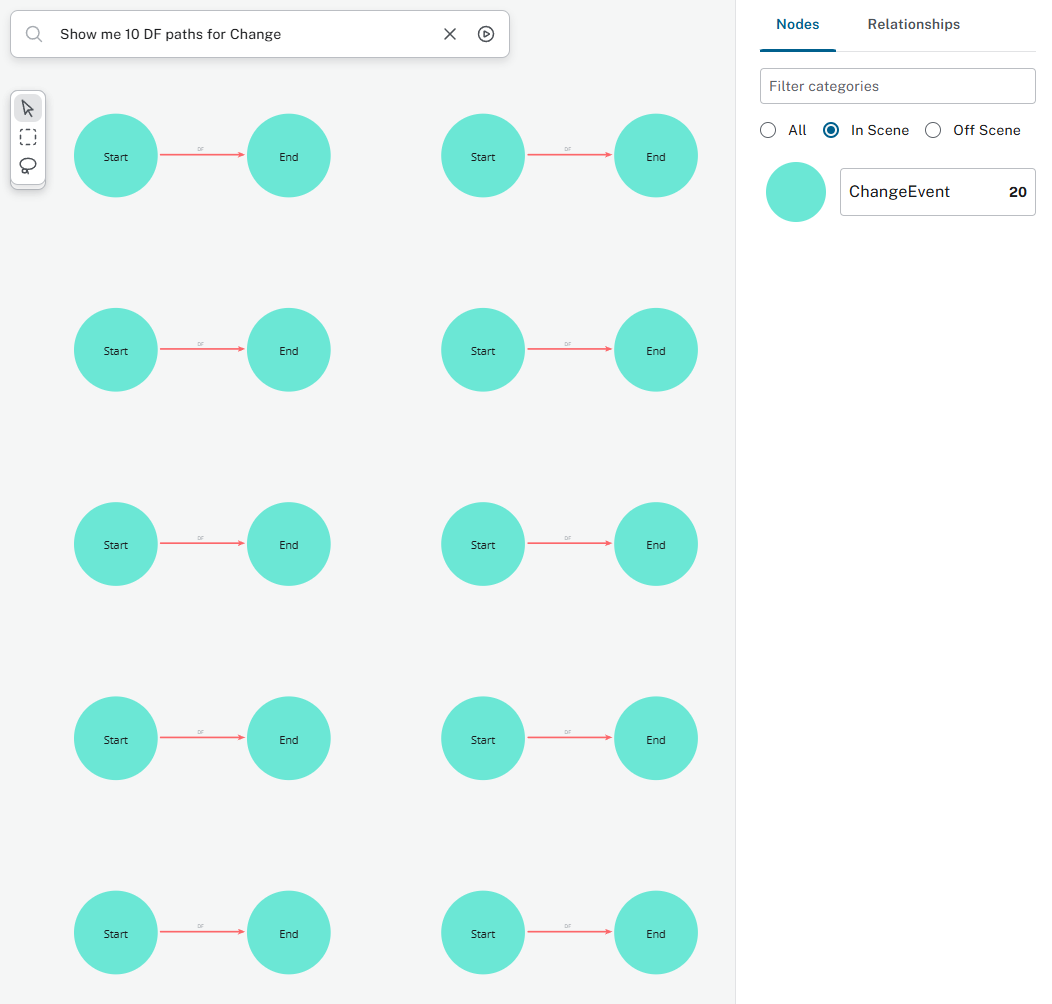
</div>

DF-Paths for Interaction
<div>
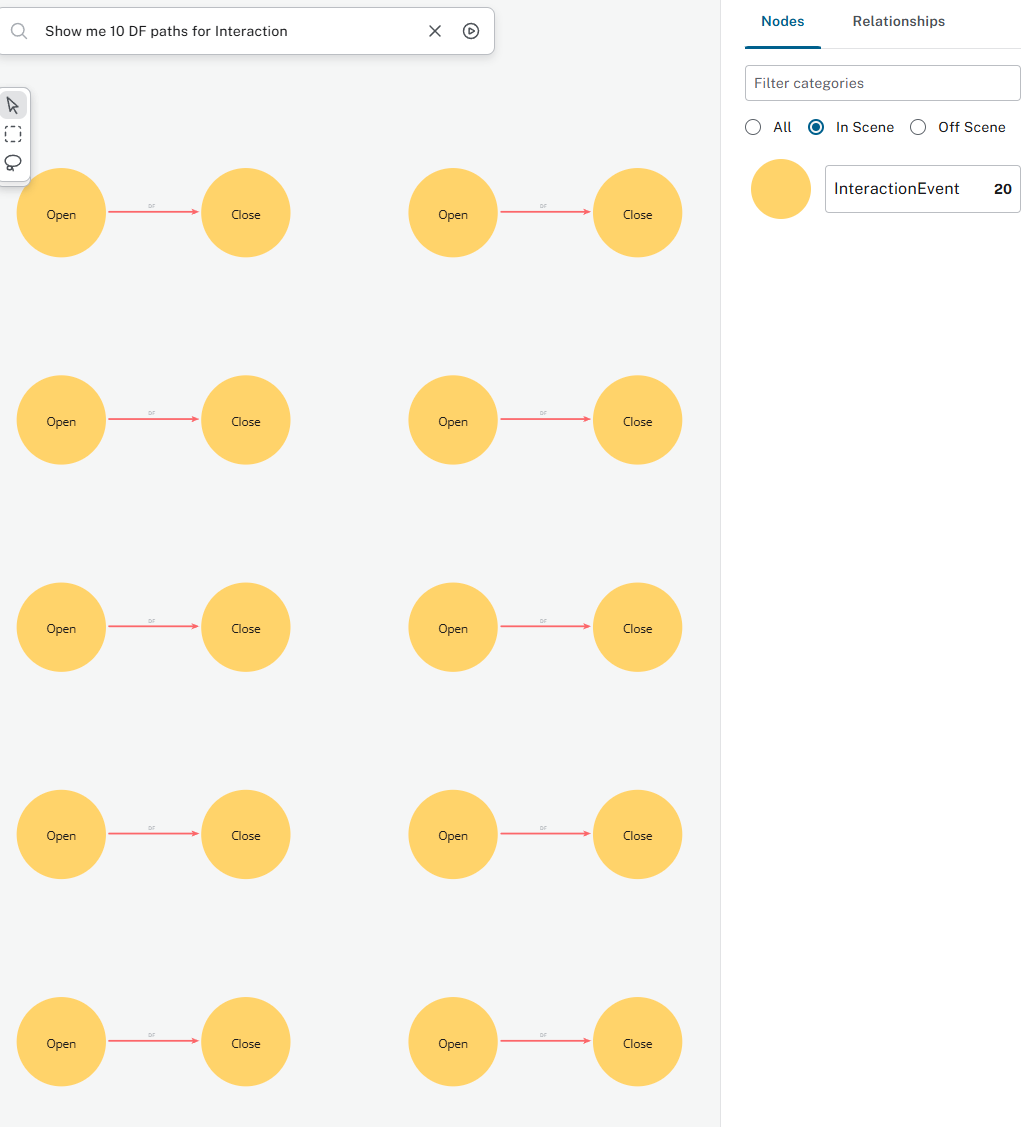
</div>

DF-Paths for Incident
<div>
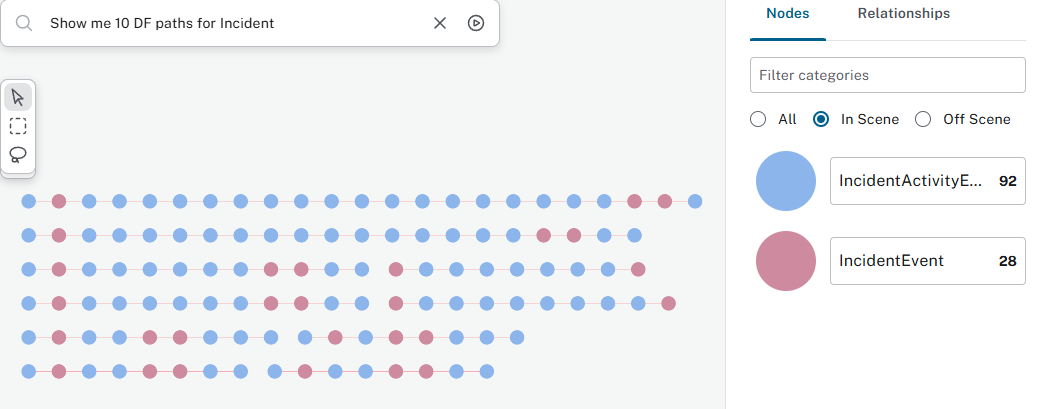
</div>

Let's zoom in on one example
<div>
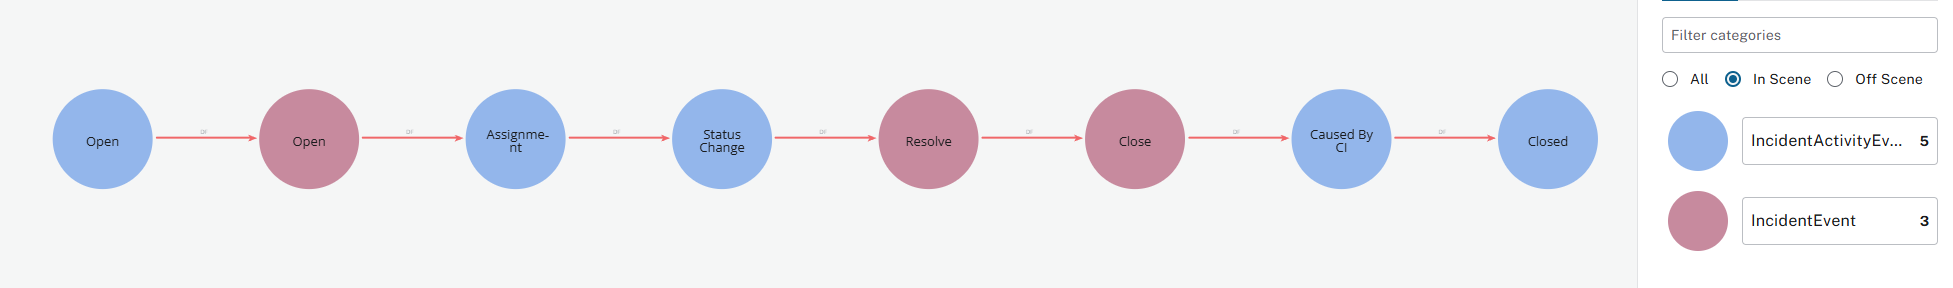
</div>

DF-Paths for CI_SC
<div>
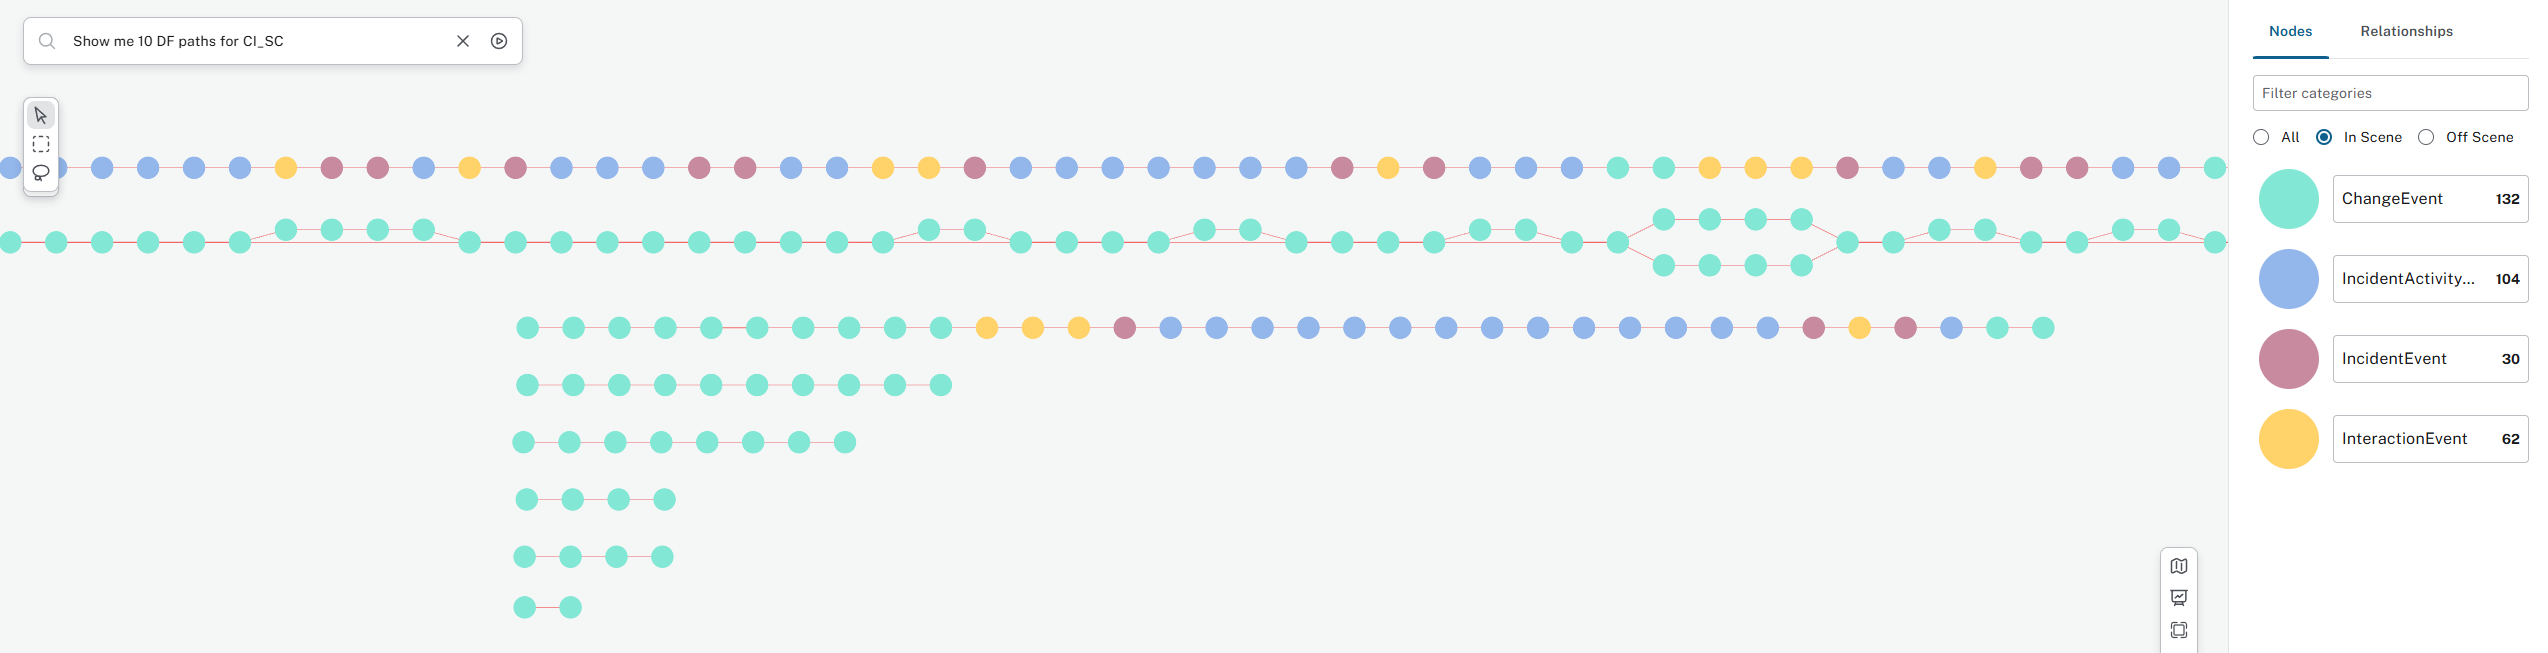
</div>

Where Change and Interaction are straightforward (existing of just two events per object), Incident and CI_SC show more variability.

Incident has two different types of events (IncidentActivityEvent and IncidentEvent).

CI_SC has all four different types of events,
there are some CI_SC that only have changes, some have all four.
Finally, there is also some interaction happening at different Change Events.

## Set Variant Analysis per CI_SC

In [262]:
def get_activity_set_variants(_db_connection, _object_type, _event_types):
    # get the bag variants on the high_level
    q_set_activity_variants_str = '''
        MATCH (:ObjectType {objectType: $objectType}) <- [:IS_OF_TYPE] - (o) -- (e) - [:IS_OF_TYPE] -> (et:EventType)
        WHERE et.eventType IN $eventTypes
        WITH o, e.activity AS activity ORDER BY activity
        WITH o, collect(distinct activity) as set_variant
        RETURN ltrim(reduce(initial = "", activity in set_variant | initial + " - (" + activity + ")" ), " - " ) as set_variant, count(o) as count_objects order by count_objects DESC
    '''

    q_set_activity_variants = Query(query_str=q_set_activity_variants_str,
                                    parameters={'objectType': _object_type,
                                                'eventTypes': event_types})

    _result = pd.DataFrame(db_connection.exec_query(q_set_activity_variants))
    _result['%_set_variant'] = round(
        _result.groupby(['set_variant']).count_objects.transform("sum") / sum(_result['count_objects']) * 100, 2)
    return _result



In [263]:
event_types = ['ChangeEvent', 'InteractionEvent', 'IncidentEvent', 'IncidentActivityEvent']
get_activity_set_variants(_db_connection=db_connection,
                          _object_type='CI_SC',
                          _event_types=event_types)

,set_variant,count_objects,%_set_variant
0,(End) - (Start),8212,63.61
1,(Close) - (Open),1554,12.04
2,(Assignment) - (Close) - (Closed) - (Open) - (...,159,1.23
3,(Assignment) - (Close) - (Closed) - (Open) - (...,115,0.89
4,(Close) - (End) - (Open) - (Start),71,0.55
...,...,...,...
1309,(Assignment) - (Caused By CI) - (Close) - (Clo...,1,0.01
1310,(Assignment) - (Caused By CI) - (Close) - (Clo...,1,0.01
1311,(Assignment) - (Close) - (Closed) - (Descripti...,1,0.01
1312,(Assignment) - (Close) - (Closed) - (Descripti...,1,0.01


These results are difficult to interpret, let's not look at the activities but the event types

In [264]:
def get_event_type_set_variants(_db_connection, _object_type, _event_types):
    # get the bag variants on the high_level
    q_set_event_type_variants_str = '''
        MATCH (:ObjectType {objectType: $objectType}) <- [:IS_OF_TYPE] - (o) -- (e:Event) - [:IS_OF_TYPE] -> (et:EventType)
        WHERE et.eventType IN $eventTypes
        WITH o, et.eventType as event_type ORDER BY event_type
        WITH o, collect(distinct event_type) as set_variant
        RETURN ltrim(reduce(initial = "", activity in set_variant | initial + " - (" + activity + ")" ), " - " ) as set_variant, count(o) as count_objects order by count_objects DESC
    '''

    q_set_event_type_variants = Query(query_str=q_set_event_type_variants_str,
                                      parameters={'objectType': 'CI_SC',
                                                  'eventTypes': event_types})

    _result = pd.DataFrame(db_connection.exec_query(q_set_event_type_variants))
    _result['%_set_variant'] = round(
        _result.groupby(['set_variant']).count_objects.transform("sum") / sum(_result['count_objects']) * 100, 2)
    return _result

In [265]:
event_types = ['ChangeEvent', 'InteractionEvent', 'IncidentEvent', 'IncidentActivityEvent']
get_event_type_set_variants(_db_connection=db_connection,
                            _object_type='CI_SC',
                            _event_types=event_types)

,set_variant,count_objects,%_set_variant
0,(ChangeEvent),8212,63.61
1,(IncidentActivityEvent) - (IncidentEvent) - (I...,2038,15.79
2,(InteractionEvent),1554,12.04
3,(ChangeEvent) - (IncidentActivityEvent) - (Inc...,531,4.11
4,(IncidentActivityEvent) - (IncidentEvent),472,3.66
5,(ChangeEvent) - (InteractionEvent),71,0.55
6,(ChangeEvent) - (IncidentActivityEvent) - (Inc...,32,0.25


Now we only have 8 variants. So most of the CI_SC (63%) are only involved in ChangeEvents, 19.6% in just Incident(Activity)Events and InteractionEvents and 11.3% only in InteractionEvent.
Only 4.66% is involved in all types of events.

Since we're interested in how the CI_SC behave over time, we can rescope our analysis to only look at the types of events.
For this, we will infer higher level events.

Instead of aggregating on the eventType level, we will aggregate on the main object they operate. So, that's for
- Change --> ChangeEvent
- Interaction --> InteractionEvent
- Incident --> IncidentActivityEvent and IncidentEvent

### Inferring HighLevelEvents

In [266]:
def infer_start_event(_db_connection, _object_type):
    # infer start and end events for each object type
    q_start_event = '''
        :auto
        // Infer start event of an object
        MATCH (o) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType: $objectType})
        MATCH (o)<-[]-(e:Event)
        WHERE NOT ()-[:DF {id:o.sysId}]->(e)
        CALL (o, e){
            MERGE (o)<-[rel:START]-(e)
            RETURN rel
        } IN TRANSACTIONS
        RETURN count(rel) as count
    '''

    q_start_event_result = Query(
        query_str=q_start_event,
        parameters={"objectType": _object_type}
    )

    res = _db_connection.exec_query(q_start_event_result)

    print(f'-> Inferred Start Events for {res[0]["count"]} objects ({_object_type})')

In [267]:
def infer_end_event(_db_connection, _object_type):
    # infer start and end events for each object type
    q_end_event = '''
        :auto
        // Infer start event of an object
        MATCH (o) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType: $objectType})
        MATCH (o)<-[]-(e:Event)
        WHERE NOT (e)-[:DF {id:o.sysId}]->()
        CALL (o, e){
            MERGE (o)<-[rel:END]-(e)
            RETURN rel
        } IN TRANSACTIONS
        RETURN count(rel) as count
    '''

    q_end_event_result = Query(
        query_str=q_end_event,
        parameters={"objectType": _object_type}
    )

    res = _db_connection.exec_query(q_end_event_result)

    print(f'-> Inferred End Events for {res[0]["count"]} objects ({_object_type})')

In [268]:
object_types = ['Interaction', 'Incident', 'Change']
for object_type in object_types:
    infer_start_event(db_connection, object_type)
    infer_end_event(db_connection, object_type)

-> Inferred Start Events for 146553 objects (Interaction)
-> Inferred End Events for 146553 objects (Interaction)
-> Inferred Start Events for 46378 objects (Incident)
-> Inferred End Events for 46378 objects (Incident)
-> Inferred Start Events for 16611 objects (Change)
-> Inferred End Events for 16616 objects (Change)


In [269]:
# materialize time between events as duration on DF edge
q_materialize_duration_on_df = '''
    :auto
    MATCH (e1:Event) - [df:DF] -> (e2:Event)
    WHERE df.duration IS NULL
    CALL (e1, df, e2) {
        SET df.duration = duration.inSeconds(e1.timestamp, e2.timestamp).seconds
    } IN TRANSACTIONS
    RETURN count(*) AS total
'''

db_connection.exec_query(q_materialize_duration_on_df)

[{'total': 1642486}]

In [270]:
# build index for high-level events
qCreateIndexHLE_sys = f'''
    CREATE INDEX highLevelEventSysIdIndex IF NOT EXISTS FOR (h:HighLevelEvent) ON (h.sysId);
'''
db_connection.exec_query(qCreateIndexHLE_sys)

qCreateIndexHLE_start = f'''
    CREATE INDEX highLevelEventStartTimeIndex IF NOT EXISTS FOR (h:HighLevelEvent) ON (h.startTime);
'''
db_connection.exec_query(qCreateIndexHLE_start)
qCreateIndexHLE_end = f'''
    CREATE INDEX highLevelEventEndTimeIndex IF NOT EXISTS FOR (h:HighLevelEvent) ON (h.endTime);
'''
db_connection.exec_query(qCreateIndexHLE_end)


[]

[]

[]

In [271]:
def infer_high_level_events(_db_connection, _object_type):
    # build high-level events
    q_build_high_level_event_str = '''
        :auto
        MATCH (o) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType: $objectType})
        MATCH (eStart:Event) - [st:START] -> (o) <- [en:END] - (eEnd:Event)
        WITH DISTINCT ot, eStart, eEnd
        CALL (eStart, eEnd, ot) {
            MERGE (h:HighLevelEvent {sysId: "HLE_" + eStart.sysId + "_" + eEnd.sysId})
            MERGE (hEventType:EventType {eventType: 'HighLevelEvent', subEventType: ot.objectType})
            MERGE (h) - [:IS_OF_TYPE] -> (hEventType)
            ON CREATE SET h.startTime=eStart.timestamp, h.endTime=eEnd.timestamp, h.activity=ot.objectType
            MERGE (h)-[:START]->(eStart)
            MERGE (h)-[:END]->(eEnd)
            RETURN h
        } IN TRANSACTIONS
        RETURN count(h) as count
    '''

    q_build_high_level_event_result = Query(
        query_str=q_build_high_level_event_str,
        parameters={"objectType": _object_type}
    )

    res = _db_connection.exec_query(q_build_high_level_event_result)
    print(f'-> Inferred {res[0]["count"]} HighLevelEvent for ObjectType ({_object_type})')


In [272]:
object_types = ['Interaction', 'Incident', 'Change']
for object_type in object_types:
    infer_high_level_events(db_connection, object_type)

-> Inferred 146553 HighLevelEvent for ObjectType (Interaction)
-> Inferred 46378 HighLevelEvent for ObjectType (Incident)
-> Inferred 16611 HighLevelEvent for ObjectType (Change)


In [273]:
def lift_e2o_relationship_to_hle(_db_connection, _object_type):
    # lift CORR to high-level events
    q_lift_e2o_str = '''
        :auto
        MATCH (h:HighLevelEvent) - [:START|END] -> () --> (o) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType: $objectType})
        WITH distinct h, o
        CALL (h, o) {
            MERGE(h) - [c:CORR] -> (o)
            RETURN c
        } IN TRANSACTIONS
        RETURN count(c) as count
    '''

    q_lift_e2o = Query(
        query_str=q_lift_e2o_str,
        parameters={"objectType": _object_type}
    )

    res = db_connection.exec_query(q_lift_e2o)
    print(f'-> Lifted {res[0]["count"]} E2O relationships for ObjectType ({_object_type})')

In [274]:
object_types = ['Interaction', 'Incident', 'Change', 'CI_SC']
for object_type in object_types:
    lift_e2o_relationship_to_hle(db_connection, object_type)

-> Lifted 146553 E2O relationships for ObjectType (Interaction)
-> Lifted 46378 E2O relationships for ObjectType (Incident)
-> Lifted 16611 E2O relationships for ObjectType (Change)
-> Lifted 219630 E2O relationships for ObjectType (CI_SC)


In [275]:
event_types = ['HighLevelEvent']
get_activity_set_variants(_db_connection=db_connection,
                          _object_type='CI_SC',
                          _event_types=event_types)

,set_variant,count_objects,%_set_variant
0,(Change),8212,63.61
1,(Incident) - (Interaction),2038,15.79
2,(Interaction),1554,12.04
3,(Change) - (Incident) - (Interaction),531,4.11
4,(Incident),472,3.66
5,(Change) - (Interaction),71,0.55
6,(Change) - (Incident),32,0.25


# BUILD HLE DF

In [276]:
# build DF relations between high-level events
# step 1: build HL-DF relations between events

def discover_df_hle(_db_connection, _object_type):
    q_build_df_relations_hle_str = '''
        :auto
        // get only START/END events of each HL event correlated to CI_SC
        MATCH (ot:ObjectType {objectType: 'CI_SC'}) <- [:IS_OF_TYPE] - (o) <- [:CORR] - (h:HighLevelEvent)
        MATCH (o) <-[:CORR]- (h) -[:START|END] -> (e:Event)
        WITH o, e ORDER BY e.timestamp, elementId(e) // order by time
        WITH o, collect(e) AS events
        UNWIND range(0, size(events)-2) AS idx
        WITH idx, events[idx] AS fromEv, events[idx+1] AS toEv, o
        CALL (o, idx, fromEv, toEv) {
            // get their HL events correlated to the same object
            MATCH (fromEv)<-[:START|END]-(h1:HighLevelEvent)-[:CORR]->(o)<-[:CORR]-(h2:HighLevelEvent)-[:START|END]->(toEv)
            WHERE h1 <> h2
            // and add their DF relation
            MERGE (h1)-[rel:DF {objectType:'CI_SC', id:o.sysId, sequence_number: idx}]->(h2)
            RETURN count(rel) as rel
        } IN TRANSACTIONS
        RETURN sum(rel) AS total

    '''

    q_build_df_relations_hle = Query(
        query_str=q_build_df_relations_hle_str,
        parameters={
            "objectType": _object,
        }
    )

    return db_connection.exec_query(q_build_df_relations_hle)

In [277]:
discover_df_hle(db_connection, _object_type='CI_SC')

[{'total': 334888}]

In [278]:
def infer_hle_start_event(_db_connection, _object_type):
    # infer start and end events for each object type
    q_start_event = '''
        :auto
        // Infer start event of an object
        MATCH (o) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType: $objectType})
        MATCH (o) <- [] - (e:HighLevelEvent) - [:DF {id:o.sysId, sequence_number:1}] -> (e2)
        CALL (o, e){
            MERGE (o)<-[rel:START]-(e)
            RETURN rel
        } IN TRANSACTIONS
        RETURN count(rel) as count
    '''

    q_start_event_result = Query(
        query_str=q_start_event,
        parameters={"objectType": _object_type}
    )

    res = _db_connection.exec_query(q_start_event_result)

    print(f'-> Inferred High Level Start Events for {res[0]["count"]} objects ({_object_type})')

In [283]:
def infer_hle_end_event(_db_connection, _object_type):
    # infer start and end events for each object type
    q_end_event = '''
        :auto
        // Infer start event of an object
        MATCH (o) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType: $objectType})
        MATCH (o) <-[] - (e:HighLevelEvent) - [df:DF {id:o.sysId}] -> (next_e:HighLevelEvent)
        WITH o, max(df.sequence_number) as last_df_index
        MATCH (o) <-[] - (before:HighLevelEvent) - [df:DF {id:o.sysId, sequence_number:last_df_index}] -> (e:HighLevelEvent)
        CALL (o, e){
            MERGE (o)<-[rel:END]-(e)
            RETURN rel
        } IN TRANSACTIONS
        RETURN count(rel) as count
    '''

    q_end_event_result = Query(
        query_str=q_end_event,
        parameters={"objectType": _object_type}
    )

    res = _db_connection.exec_query(q_end_event_result)

    print(f'-> Inferred High Level End Events for {res[0]["count"]} objects ({_object_type})')

In [284]:
infer_hle_start_event(_db_connection=db_connection,
                      _object_type='CI_SC')
infer_hle_end_event(_db_connection=db_connection,
                    _object_type='CI_SC')

-> Inferred High Level Start Events for 11100 objects (CI_SC)
-> Inferred High Level End Events for 8623 objects (CI_SC)


# Discover different NBags
For every shortest trace from the first event of a CI_SC until the last event of a CI_SC, we determine sequences of a specific length, so called nbags.
Then for every CI_SC, we also request the type


In [285]:
def get_nbag(size):
    q_get_nbags_str = '''
        MATCH (start:HighLevelEvent) - [:START] -> (o) - [:IS_OF_TYPE] -> (:ObjectType {objectType: 'CI_SC'})
        MATCH (o) - [:RELATED] -> (ci:ConfigurationItem)
        MATCH (end:HighLevelEvent) - [:END] -> (o)
        MATCH p = SHORTEST 1 (start) - [:DF* {id:o.sysId}] -> (end)
        UNWIND nodes(p) as event
        WITH o, ci, event.activity as activity order by event.timestamp
        WITH o, ci, collect(activity) as activities
        WITH o, ci, [i in range(0, size(activities) - 1) WHERE i = 0 OR activities[i] <> activities[i-1] | activities[i]] AS activities
        UNWIND range(0, size(activities) - $size) as i
        WITH o, ci, activities[i..i+$size] as nbag_list
        RETURN ci.ciType as type, ci.ciType as subtype, ltrim(reduce(init="", t in nbag_list| init + "-" + t), '-') as nbag, count(nbag_list) as nbag_count
    '''

    q_get_nbags = Query(query_str=q_get_nbags_str,
                        template_string_parameters={
                            "size": size
                        })

    results = db_connection.exec_query(q_get_nbags)
    nbags = pd.DataFrame(results)
    table = pd.pivot_table(nbags, index=['nbag', 'type', 'subtype'], aggfunc="sum")
    table['%'] = (
        round(
            table.groupby(['nbag', 'type', 'subtype']).nbag_count.transform("sum") /
            sum(table.nbag_count) * 100,
            2
        )
    )
    return table

In [286]:
get_nbag(1)

nbag_count      %
nbag        type                 subtype                                
Change      Phone                Phone                          3   0.02
            application          application                 1062   6.62
            applicationcomponent applicationcomponent         214   1.33
            computer             computer                    1872  11.68
            database             database                     274   1.71
            hardware             hardware                     124   0.77
            networkcomponents    networkcomponents            438   2.73
            no type              no type                        4   0.02
            officeelectronics    officeelectronics              1   0.01
            software             software                     229   1.43
            storage              storage                      137   0.85
            subapplication       subapplication               229   1.43
Incident    application          application                 2675  16.69
            applicationcomponent applicationcomponent           2   0.01
            computer             computer                    1579   9.85
            database             database                      61   0.38
            displaydevice        displaydevice                 66   0.41
            hardware             hardware                     171   1.07
            networkcomponents    networkcomponents             65   0.41
            no type              no type                       35   0.22
            officeelectronics    officeelectronics             68   0.42
            software             software                     119   0.74
            storage              storage                      131   0.82
            subapplication       subapplication               623   3.89
Interaction #N/B                 #N/B                           1   0.01
            application          application                 3132  19.54
            applicationcomponent applicationcomponent           1   0.01
            computer             computer                    1314   8.20
            database             database                      61   0.38
            displaydevice        displaydevice                 69   0.43
            hardware             hardware                     187   1.17
            networkcomponents    networkcomponents             49   0.31
            no type              no type                       34   0.21
            officeelectronics    officeelectronics             68   0.42
            software             software                     128   0.80
            storage              storage                      127   0.79
            subapplication       subapplication               678   4.23

In [287]:
get_nbag(2)

nbag_count      %
nbag                 type                 subtype                                
Change-Incident      application          application                   36   0.34
                     computer             computer                      12   0.11
                     database             database                       1   0.01
                     hardware             hardware                       5   0.05
                     networkcomponents    networkcomponents              1   0.01
                     software             software                       2   0.02
                     subapplication       subapplication                 5   0.05
Change-Interaction   application          application                  511   4.86
                     computer             computer                     115   1.09
                     database             database                       2   0.02
                     hardware             hardware                      44   0.42
                     networkcomponents    networkcomponents             13   0.12
                     no type              no type                        3   0.03
                     officeelectronics    officeelectronics              1   0.01
                     software             software                      19   0.18
                     storage              storage                       37   0.35
                     subapplication       subapplication                61   0.58
Incident-Change      application          application                  141   1.34
                     computer             computer                      47   0.45
                     hardware             hardware                      26   0.25
                     networkcomponents    networkcomponents              1   0.01
                     software             software                      11   0.10
                     storage              storage                       14   0.13
                     subapplication       subapplication                24   0.23
Incident-Interaction application          application                 2415  22.97
                     applicationcomponent applicationcomponent           1   0.01
                     computer             computer                     897   8.53
                     database             database                      57   0.54
                     displaydevice        displaydevice                 60   0.57
                     hardware             hardware                     126   1.20
                     networkcomponents    networkcomponents             33   0.31
                     no type              no type                       28   0.27
                     officeelectronics    officeelectronics             52   0.49
                     software             software                      97   0.92
                     storage              storage                       85   0.81
                     subapplication       subapplication               585   5.56
Interaction-Change   application          application                  372   3.54
                     computer             computer                      56   0.53
                     database             database                       1   0.01
                     hardware             hardware                      15   0.14
                     networkcomponents    networkcomponents              7   0.07
                     no type              no type                        1   0.01
                     officeelectronics    officeelectronics              1   0.01
                     software             software                      14   0.13
                     storage              storage                       19   0.18
                     subapplication       subapplication                39   0.37
Interaction-Incident application          application                 2445  23.26
                     applicationcomponent appl

In [288]:
get_nbag(3)

nbag_count     %
nbag                             type              subtype                            
Change-Incident-Change           application       application                14  0.16
                                 computer          computer                    9  0.10
                                 hardware          hardware                    3  0.03
                                 subapplication    subapplication              2  0.02
Change-Incident-Interaction      application       application                18  0.20
...                                                                          ...   ...
Interaction-Incident-Interaction no type           no type                    21  0.24
                                 officeelectronics officeelectronics          33  0.37
                                 software          software                   81  0.91
                                 storage           storage                    51  0.58
                                 subapplication    subapplication            542  6.12

[87 rows x 2 columns]

# CI_SC Check
CI_SC are often handled simulatenously. Sometimes, they go then on to a different route and come back later at a different point in time
Let's check what happens in between these two events

In [368]:
def get_ci_scs_in_sync(db_connection):
    query = '''
            :auto


        MATCH (e:HighLevelEvent) - [:CORR] -> (o1) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType:'CI_SC'})
MATCH (e) - [:CORR] -> (o2) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType:'CI_SC'})
WHERE o1 < o2
WITH e, o1, o2
CALL (e, o1, o2){
  MATCH (f:HighLevelEvent)  - [:CORR] -> (o1)
  MATCH (f) - [:CORR] -> (o2)
  WHERE f.startTime >= e.startTime AND e <> f
  RETURN f ORDER BY f.startTime limit 1
} IN TRANSACTIONS
CALL (o1, e, f){
  MATCH p = SHORTEST 1 (e) - [:DF* {id: o1.sysId}] -> (f)
  WITH p, nodes(p)[1..-1] as events
  CALL (events) {
    UNWIND events as event
    WITH event ORDER BY event.activity
    RETURN collect(distinct event.activity) as set_variant
    }
  RETURN nodes(p) as p_o1, set_variant as set_variant_o1
} IN TRANSACTIONS
CALL (o2, e, f){
    MATCH p = SHORTEST 1 (e) - [:DF* {id: o2.sysId}] -> (f)
  WITH p, nodes(p)[1..-1] as events
  CALL (events) {
    UNWIND events as event
    WITH event ORDER BY event.activity
    RETURN collect(distinct event.activity) as set_variant
    }

  RETURN nodes(p) as p_o2,  set_variant as  set_variant_o2

} IN TRANSACTIONS
    MATCH (o1) - [:RELATED] -> (ci1:ConfigurationItem)
    MATCH (o2) - [:RELATED] -> (ci2:ConfigurationItem)
    WITH o1, ci1, o2, ci2, p_o1, p_o2, set_variant_o1, set_variant_o2

    CALL (set_variant_o1, set_variant_o2) {
    WITH set_variant_o1, set_variant_o2, CASE
        WHEN size(set_variant_o1) <= size(set_variant_o2) THEN set_variant_o1
        ELSE set_variant_o2 END AS first_interruptions
    WITH set_variant_o1, set_variant_o2, first_interruptions, CASE
        WHEN first_interruptions = set_variant_o1 THEN set_variant_o2
        ELSE set_variant_o1 END AS second_interruptions
    WITH set_variant_o1, set_variant_o2, CASE
        WHEN size(first_interruptions) = 0 THEN " None"
        ELSE ltrim(reduce(init="", item in first_interruptions | init + "-" + item), '-')  END AS interruptions_o1,
    CASE
        WHEN size(second_interruptions) = 0 THEN " None"
        ELSE ltrim(reduce(init="", item in second_interruptions | init + "-" + item), '-') END AS interruptions_o2
    RETURN interruptions_o1, interruptions_o2}
    RETURN ci1.ciType as c1Type, ci1.ciSubtype as c1Subtype, ci2.ciType as c2Type, ci2.ciSubtype as c2Subtype, interruptions_o1, interruptions_o2, count(o1) as occurrences

    '''

    result = pd.DataFrame(db_connection.exec_query(query=query))
    table = pd.pivot_table(result, index=['interruptions_o1', 'interruptions_o2', 'c1Type', 'c1Subtype', 'c2Type', 'c2Subtype'], aggfunc="sum")
    table['%'] = (
        round(
            table.groupby(['interruptions_o1', 'interruptions_o2', 'c1Type', 'c1Subtype', 'c2Type', 'c2Subtype']).occurrences.transform("sum") /
            sum(table.occurrences) * 100,
            2
        )
    )
    return table


In [369]:
result = get_ci_scs_in_sync(db_connection)
result

occurrences     %
interruptions_o1 interruptions_o2     c1Type      c1Subtype                c2Type         c2Subtype                                  
 None             None                application Desktop Application      application    Desktop Application                 5  0.04
                                                  Server Based Application application    Server Based Application          135  1.05
                                                                           software       Server Based Application           24  0.19
                                                                           subapplication Server Based Application            8  0.06
                                                                                          Web Based Application              14  0.11
...                                                                                                                         ...   ...
Interaction      Incident-Interaction storage     Controller               storage        Controller                          1  0.01
                 Interaction          application Server Based Application application    Server Based Application            1  0.01
                                      computer    Desktop                  computer       Desktop                             1  0.01
                                                  Laptop                   computer       Laptop                              1  0.01
                                      storage     Controller               storage        Controller                          1  0.01

[474 rows x 2 columns]

In [370]:
new_result = result.reset_index()
new_result = new_result.drop(columns=['c1Type', 'c1Subtype', 'c2Type', 'c2Subtype', '%'])
table = pd.pivot_table(new_result, index=['interruptions_o1', 'interruptions_o2'], aggfunc="sum")
table['%'] = (
    round(
        table.groupby(['interruptions_o1', 'interruptions_o2']).occurrences.transform("sum") /
        sum(table.occurrences) * 100,
        2
    )
)
table


occurrences      %
interruptions_o1            interruptions_o2                               
 None                        None                               7792  60.83
                            Change                              2388  18.64
                            Change-Incident                        3   0.02
                            Change-Incident-Interaction           83   0.65
                            Change-Interaction                    48   0.37
                            Incident                               7   0.05
                            Incident-Interaction                  92   0.72
                            Interaction                           49   0.38
Change                      Change                              2035  15.89
                            Change-Incident                        7   0.05
                            Change-Incident-Interaction           98   0.77
                            Change-Interaction                    28   0.22
                            Incident                               3   0.02
                            Incident-Interaction                  35   0.27
                            Interaction                           11   0.09
Change-Incident             Change-Incident-Interaction            2   0.02
Change-Incident-Interaction Change-Incident-Interaction           23   0.18
Change-Interaction          Change-Incident                        1   0.01
                            Change-Incident-Interaction           23   0.18
                            Change-Interaction                     1   0.01
Incident                    Change-Incident-Interaction            1   0.01
                            Change-Interaction                     1   0.01
Incident-Interaction        Change-Incident-Interaction            8   0.06
                            Change-Interaction                     4   0.03
                            Incident-Interaction                  26   0.20
Interaction                 Change                                 4   0.03
                            Change-Incident                        1   0.01
                            Change-Incident-Interaction            9   0.07
                            Change-Interaction                     5   0.04
                            Incident-Interaction                  18   0.14
                            Interaction                            4   0.03

In [367]:
new_result.columns

Index(['interruptions_o1', 'interruptions_o2', 'occurrences'], dtype='object')